# <b> <center> <font color='#7B241C'> OBJECT DETECTION - MULTIPLE OBJECTS </font> </center> </b>

## <font color='blue'> Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Helper Functions](#3)
4. [Data Generation and Pre-processing](#4)
5. [Build, compile and train the model](#5)
6. [Making predictions](#6)
7. [References](#references)

<a name="1"></a>
## <b> <font color='red'> 1. Introduction </font> </b>

In this notebook, we train an object detection model capable of identifying and localizing multiple objects within the same image. Unlike simple classification tasks, object detection involves predicting both the class and bounding box for each object present.

To simplify data acquisition and maintain control over object placement and variety, we use synthetic data—artificially generated images containing different shapes (e.g., circles, squares) positioned at random locations. This allows us to simulate real-world conditions where multiple distinct objects can appear simultaneously in a single frame.

The main goals of this notebook are:

Generate a synthetic dataset with labeled bounding boxes and classes for multiple objects per image.

Build and train an object detection model.

Evaluate the model’s ability to detect and localize each object in new images.

This project is a foundational step for tasks like automated visual inspection, multi-object tracking, and real-time detection systems.

<a name="2"></a>
## <b> <font color='red'> 2. Setup </font> </b>

In [20]:
import tensorflow as tf
import numpy as np
from PIL import Image, ImageDraw
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tensorflow.keras import layers, Model

In [2]:
tf.random.set_seed(42)

<a name="3"></a>
## <b> <font color='red'> 3. Helper Functions </font> </b>

In [3]:
def plot_sample(img_array, labels, bboxes):
    fig, ax = plt.subplots()
    ax.imshow(img_array)

    class_names = ["square", "circle"]
    colors = ["violet", "yellow"]

    for cls in range(len(labels)):
        if labels[cls]:  # if object is present
            x1, y1, x2, y2 = bboxes[cls] * IMG_SIZE  # denormalize
            width, height = x2 - x1, y2 - y1
            rect = patches.Rectangle((x1, y1), width, height,
                                     linewidth=2, edgecolor=colors[cls],
                                     facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1 - 5, class_names[cls], color=colors[cls], fontsize=12)

    plt.axis("off")
    plt.show()


<a name="4"></a>
## <b> <font color='red'> 4. Data Generation and Pre-processing </font> </b>

We will generate synthetic data.

In [4]:
IMG_SIZE = 64
NUM_CLASSES = 2  # red square, blue circle

# ==== DATA GENERATION ====
def generate_sample():
    img = Image.new("RGB", (IMG_SIZE, IMG_SIZE), "black")
    draw = ImageDraw.Draw(img)

    labels = np.zeros(NUM_CLASSES)
    bboxes = np.zeros((NUM_CLASSES, 4))  # x1, y1, x2, y2

    for cls in range(NUM_CLASSES):
        x1, y1 = random.randint(5, 30), random.randint(5, 30)
        x2, y2 = x1 + 20, y1 + 20

        if cls == 0: draw.rectangle([x1, y1, x2, y2], fill="red")
        if cls == 1: draw.ellipse([x1, y1, x2, y2], fill="blue")

        labels[cls] = 1
        bboxes[cls] = np.array([x1, y1, x2, y2]) / IMG_SIZE  # normalize

    img_array = np.array(img) / 255.0
    return img_array, labels, bboxes

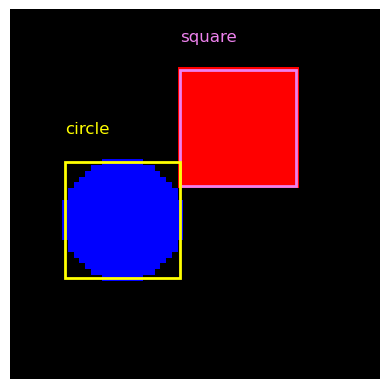

In [5]:
# Example usage:
img_array, labels, bboxes = generate_sample()
plot_sample(img_array, labels, bboxes)

Let's create the dataset.

In [6]:
def create_dataset(num_samples=1000):
    X, y_cls, y_bbox = [], [], []
    for _ in range(num_samples):
        img, labels, bboxes = generate_sample()
        X.append(img)
        y_cls.append(labels)
        y_bbox.append(bboxes)
    return np.array(X), np.array(y_cls), np.array(y_bbox)

X_train, y_train_cls, y_train_bbox = create_dataset()

Now, let's create the TF Datasets.

In [7]:
# Generate training and validation sets
X_train, y_train_cls, y_train_bbox = create_dataset(num_samples=1000)
X_val, y_val_cls, y_val_bbox = create_dataset(num_samples=200)

# Create TensorFlow Datasets
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train, {"cls": y_train_cls, "bbox": y_train_bbox})
)

val_ds = tf.data.Dataset.from_tensor_slices(
    (X_val, {"cls": y_val_cls, "bbox": y_val_bbox})
)

# Shuffle, batch, and prefetch
BATCH_SIZE = 32

train_ds = (
    train_ds.shuffle(buffer_size=len(X_train))
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE)
)

# no shuffle
val_ds = (
    val_ds.batch(BATCH_SIZE)
          .prefetch(tf.data.AUTOTUNE)
)


<a name="5"></a>
## <b> <font color='red'> 5. Build, compile and train the model </font> </b>

In [8]:
def create_simple_model(img_size=64, num_classes=2):
    inputs = layers.Input(shape=(img_size, img_size, 3))

    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)

    # Output for classification: multi-label (presence of each class)
    cls_output = layers.Dense(num_classes, activation='sigmoid', name='cls')(x)

    # Output for bounding boxes: 4 coordinates per class (x1, y1, x2, y2)
    bbox_output = layers.Dense(num_classes * 4, activation='sigmoid')(x)
    bbox_output = layers.Reshape((num_classes, 4), name='bbox')(bbox_output)

    model = Model(inputs=inputs, outputs=[cls_output, bbox_output])
    return model


NUM_CLASSES = 2 # circle and square

# Example usage
model = create_simple_model(img_size=IMG_SIZE, num_classes=NUM_CLASSES)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 32)           896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           18496     ['max_pooling2d[0][0]']   

In [9]:
# Compile example (adjust loss and metrics as needed)
model.compile(
    optimizer='adam',
    loss={
        "cls": tf.keras.losses.BinaryCrossentropy(from_logits=False),
        "bbox": tf.keras.losses.MeanSquaredError()
    },
    metrics={
        "cls": tf.keras.metrics.BinaryAccuracy(),
        "bbox": tf.keras.metrics.MeanAbsoluteError()
    }
)

# Fit the model using the datasets created before
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
32/32 [==============================] - 4s 84ms/step - loss: 0.0542 - cls_loss: 0.0317 - bbox_loss: 0.0225 - cls_binary_accuracy: 0.9865 - bbox_mean_absolute_error: 0.1076 - val_loss: 0.0033 - val_cls_loss: 6.7335e-05 - val_bbox_loss: 0.0033 - val_cls_binary_accuracy: 1.0000 - val_bbox_mean_absolute_error: 0.0452
Epoch 2/10
32/32 [==============================] - 3s 79ms/step - loss: 0.0013 - cls_loss: 8.0293e-05 - bbox_loss: 0.0012 - cls_binary_accuracy: 1.0000 - bbox_mean_absolute_error: 0.0264 - val_loss: 7.3242e-04 - val_cls_loss: 7.4082e-05 - val_bbox_loss: 6.5834e-04 - val_cls_binary_accuracy: 1.0000 - val_bbox_mean_absolute_error: 0.0193
Epoch 3/10
32/32 [==============================] - 3s 81ms/step - loss: 4.7393e-04 - cls_loss: 4.9340e-05 - bbox_loss: 4.2459e-04 - cls_binary_accuracy: 1.0000 - bbox_mean_absolute_error: 0.0157 - val_loss: 4.4110e-04 - val_cls_loss: 3.5815e-05 - val_bbox_loss: 4.0529e-04 - val_cls_binary_accuracy: 1.0000 - val_bbox_mean_absolute_e

<a name="6"></a>
## <b> <font color='red'> 6. Making predictions </font> </b>

In [ ]:
img = X_val[7]
pred_cls, pred_bbox = model.predict(np.expand_dims(img, 0), verbose=0)

In [18]:
pred_cls

array([[0.99999833, 0.9999991 ]], dtype=float32)

**Classification output**

Shape: (1, 2) — 1 sample, 2 classes.

Each value is between 0 and 1, representing the predicted probability (confidence) that each class is present in the image.

In this example:

- Class 0 (e.g., square) confidence ≈ 0.99999833 → very confident the object is present.

- Class 1 (e.g., circle) confidence ≈ 0.9999991 → very confident the object is present.

In [16]:
pred_bbox

array([[[0.47013748, 0.2053786 , 0.7740922 , 0.5240758 ],
        [0.19972506, 0.18141209, 0.5215569 , 0.4973964 ]]], dtype=float32)

**Bounding Box Output**

Shape: (1, 2, 4) — 1 sample, 2 classes, 4 coordinates per box.

Each bounding box is represented as [x1, y1, x2, y2], normalized between 0 and 1 relative to image size.

- For class 0 (square):
    - Bounding box: [0.4701, 0.2053, 0.7741, 0.5241] <br> <br>


- For class 1 (circle):
    - Bounding box: [0.1997, 0.1814, 0.5216, 0.4974]

In [12]:
# ==== INFERENCE EXAMPLE ====
def show_prediction(model, X, idx=0):
    img = X[idx]
    pred_cls, pred_bbox = model.predict(np.expand_dims(img, 0), verbose=0)
    pred_cls, pred_bbox = pred_cls[0], pred_bbox[0]

    fig, ax = plt.subplots()
    ax.imshow(img)

    class_names = ["Red Square", "Blue Circle"]
    colors = ['violet', 'yellow']

    for i in range(NUM_CLASSES):
        confidence = pred_cls[i]
        if confidence > 0.5:
            x1, y1, x2, y2 = pred_bbox[i] * IMG_SIZE
            width, height = x2 - x1, y2 - y1
            rect = plt.Rectangle((x1, y1), width, height,
                                 edgecolor=colors[i], facecolor='none', linewidth=2)
            ax.add_patch(rect)
            ax.text(x1, y1 - 2, f"{class_names[i]} ({confidence:.2f})",
                    color=colors[i], fontsize=8, backgroundcolor='black')
    plt.axis('off')
    plt.show()


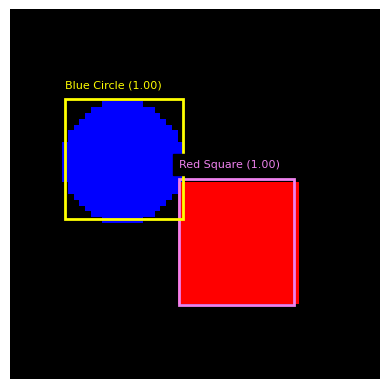

In [19]:
show_prediction(model, X_val, 9)

<a name="references"></a>
## <b> <font color='red'> References </font>  </b>

[Advanced Computer Vision with TF](https://www.coursera.org/learn/advanced-computer-vision-with-tensorflow?specialization=tensorflow-advanced-techniques)